In [27]:
%matplotlib inline
import glob
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
from PIL import Image
from collections import Counter
import numpy as np

In [28]:
def read_json(filename):
    with Path(filename).open(encoding='utf8') as handle:
        ann = json.load(handle)
    return ann

In [29]:
# gt file과 raw image file path를 이용해 데이터를 불러온다. 아래 경로는 예시.
data = read_json("/opt/ml/input/data/ICDAR17_Korean/ufo/train.json")

In [30]:
def get_box_size(quads):
    """ 단어 영역의 사각형 좌표가 주어졌을 때 가로, 세로길이를 계산해주는 함수.
    TODO: 각 변의 길이를 단순히 max로 처리하기때문에 직사각형에 가까운 형태가 아니면 약간 왜곡이 있다.
    Args:
        quads: np.ndarray(n, 4, 2) n개 단어 bounding-box의 4개 점 좌표 (단위 pixel)
    Return:
        sizes: np.ndarray(n, 2) n개 box의 (height, width)쌍
    """
    dists = []
    for i, j in [(1, 2), (3, 0), (0, 1), (2, 3)]: # [right(height), left(height), upper(width), lower(width)] sides
        dists.append(np.linalg.norm(quads[:, i] - quads[:, j], ord=2, axis=1))

    dists = np.stack(dists, axis=-1).reshape(-1, 2, 2) # shape (n, 2, 2) widths, heights into separate dim
    return np.rint(dists.mean(axis=-1)).astype(int)

In [31]:
def rectify_poly(poly, direction, img_w, img_h):
    """일반 polygon형태인 라벨을 크롭하고 rectify해주는 함수.
    Args:
        poly: np.ndarray(2n+4, 2) (where n>0), 4, 6, 8
        image: np.ndarray opencv 포멧의 이미지
        direction: 글자의 읽는 방향과 진행 방향의 수평(Horizontal) 혹은 수직(Vertical) 여부
    Return:
        rectified: np.ndarray(2, ?) rectify된 단어 bbox의 사이즈.
    """
    
    n_pts = poly.shape[0]
    assert n_pts % 2 == 0
    if n_pts == 4:
        size = get_box_size(poly[None])
        h = size[:, 0] / img_h
        w = size[:, 1] / img_w
        return np.stack((h,w))

    def unroll(indices):
        return list(zip(indices[:-1], indices[1:]))

    # polygon하나를 인접한 사각형 여러개로 쪼갠다.
    indices = list(range(n_pts))
    if direction == 'Horizontal':
        upper_pts = unroll(indices[:n_pts // 2]) # (0, 1), (1, 2), ... (4, 5)
        lower_pts = unroll(indices[n_pts // 2:])[::-1] # (8, 9), (7, 8), ... (6, 7)

        quads = np.stack([poly[[i, j, k, l]] for (i, j), (k, l) in zip(upper_pts, lower_pts)])
    else:
        right_pts = unroll(indices[1:n_pts // 2 + 1]) # (1, 2), (2, 3), ... (4, 5)
        left_pts = unroll([0] + indices[:n_pts // 2:-1]) # (0, 9), (9, 8), ... (7, 6)

        quads = np.stack([poly[[i, j, k, l]] for (j, k), (i, l) in zip(right_pts, left_pts)])

    sizes = get_box_size(quads)
    if direction == 'Horizontal':
        h = sizes[:, 0].max() / img_h
        widths = sizes[:, 1]
        w = np.sum(widths) / img_w
        return np.stack((h,w)).reshape(2,-1)
        #return np.stack((h,w))
    elif direction == 'Vertical':
        heights = sizes[:, 0]
        w = sizes[:, 1].max() / img_w
        h = np.sum(heights) / img_h
        return np.stack((h,w)).reshape(2,-1)
    else:
        h = sizes[:, 0] / img_h
        w = sizes[:, 1] / img_w
        return np.stack((h,w),-1)

In [32]:
df = {}
df['image'] = []
df['word_counts'] = []
df['image_width'] = []
df['image_height'] = []
df['image_tags'] = []
img_tags = []

quads = []
polys = []
seq_length = []
hor_sizes = []
ver_sizes = []
irr_sizes = []
languages = []
orientation = []
word_tags = []
aspect_ratio = []
ver_string = []
words = []

for image_key, image_value in data["images"].items():
    df['image'].append(image_key)
    img_w = image_value['img_w']
    img_h = image_value['img_h']
    df['image_width'].append(img_w)
    df['image_height'].append(img_h)
    df['image_tags'].append(image_value['tags'])
    df['image_tags']= [['None'] if v is None else v for v in df['image_tags']] # our data does not inlcude multi-tag images 
    word_ann = image_value['words']
    count_ill = 0
    points = []
    for word in word_ann.values():
        if word['illegibility']== False:
            orientation.append(word['orientation'])
            orientation = [v for v in orientation]
            seq_length.append(len(word['transcription']))
            languages.append(word['language'])
            languages = [['None'] if v is None else v for v in languages] # our data does not inlcude multi-language words
            if word['word_tags'] != None:
                word_tags.extend(word['word_tags'][:])
            elif word['word_tags']== None:
                word_tags.append('None')
            poly = np.int32(word['points'])
            points.append(poly)
            size = rectify_poly(poly, word['orientation'], img_w, img_h)
            if word['orientation'] == 'Horizontal':
                hor_sizes.append(size)
            elif word['orientation'] == 'Vertical':
                ver_sizes.append(size)
            else:
                irr_sizes.append(size)            
        else:
            count_ill += 1
    df['word_counts'].append(len(word_ann)-count_ill)
    words.append(points)

df['words'] = words            
all_sizes = hor_sizes + ver_sizes + irr_sizes
quad_area = [all_sizes[i][0]*all_sizes[i][1] for i in range(len(all_sizes))]
total_area = []
for s in quad_area:
    if s.shape[0] == 1:
        total_area.append(np.sum(s[0])) 
    else:
        total_area.append(np.sum(s))

hor_aspect_ratio = [hor_sizes[i][1]/hor_sizes[i][0] for i in range(len(hor_sizes))]
ver_aspect_ratio = [ver_sizes[i][1]/ver_sizes[i][0] for i in range(len(ver_sizes))]

image_df = pd.DataFrame.from_dict(df)

In [33]:
image_df['image_tags'] = image_df['image_tags'].apply(lambda x: ','.join(map(str, x)))
image_df

,image,word_counts,image_width,image_height,image_tags,words
0,img_4380.jpg,3,1836,2448,None,"[[[662, 747], [945, 759], [922, 1582], [673, 1..."
1,img_4583.jpg,2,2268,2268,None,"[[[323, 912], [1747, 943], [1747, 1142], [337,..."
2,img_4234.jpg,7,2592,3456,None,"[[[380, 898], [1189, 934], [1193, 1659], [394,..."
3,img_4345.jpg,7,1836,2448,None,"[[[93, 1501], [377, 1506], [367, 1622], [82, 1..."
4,img_4016.jpg,1,1836,2448,None,"[[[206, 2011], [1357, 1944], [1347, 2212], [23..."
...,...,...,...,...,...,...
531,img_1048.jpg,4,3024,2268,None,"[[[207, 996], [739, 1009], [742, 1261], [217, ..."
532,img_1071.jpg,2,2448,1836,None,"[[[260, 519], [534, 523], [522, 1132], [181, 1..."
533,img_1122.jpg,8,2448,1836,None,"[[[1402, 202], [1715, 209], [1707, 301], [1398..."
534,img_1131.jpg,1,3144,2328,None,"[[[556, 849], [2451, 863], [2438, 1227], [543,..."


In [34]:
image_df['image_tags'].describe()

count      536
unique       1
top       None
freq       536
Name: image_tags, dtype: object

In [35]:
# just for checking
list(data['images'].keys())[0]

'img_4380.jpg'

In [36]:
first_img = list(data['images'].keys())[0]
data["images"][first_img].keys()

dict_keys(['img_h', 'img_w', 'words', 'tags', 'license_tag'])

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


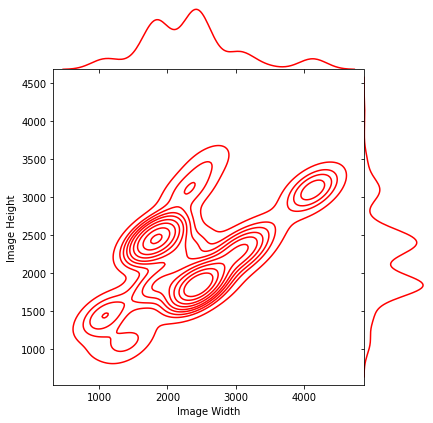

In [37]:
# image width, height 
g = sns.jointplot("image_width", "image_height", data=image_df, kind="kde", space=0, color="r")
g.set_axis_labels("Image Width", "Image Height")

In [38]:
import cv2
from matplotlib import cm

def get_colormap_from_gray_pixel(pixel:np.ndarray) -> np.ndarray:
    color_pixel = cv2.applyColorMap(pixel, cv2.COLORMAP_JET)
    return color_pixel

457 is selected in 536
0      None
1      None
2      None
3      None
4      None
       ... 
531    None
532    None
533    None
534    None
535    None
Name: image_tags, Length: 536, dtype: object


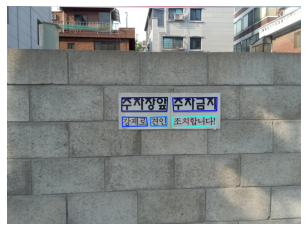

In [59]:
from PIL import Image

seed = 202111
np.random.seed(seed)

images_len = len(image_df)
selected_num = int(np.random.randint(images_len, size=1))
print(f'{selected_num} is selected in {images_len}')

labels = []
colors = []
for index, row in enumerate(image_df):
    labels.append(index)
    gray_pixel = [255. * index / len(row)]
    gray_pixel = np.array(gray_pixel, dtype=np.float32)
    gray_pixel = cv2.cvtColor(gray_pixel, cv2.COLOR_GRAY2RGB).astype(np.uint8)
    color_pixel = get_colormap_from_gray_pixel(gray_pixel)
    colors.append(np.squeeze(color_pixel))

folder_path = '/opt/ml/input/data/ICDAR17_Korean/images'
file_path = os.path.join(folder_path, image_df.image[selected_num])
image = cv2.imread(file_path, cv2.IMREAD_COLOR)

for index, points in enumerate(image_df.words[selected_num]):
    image = cv2.polylines(image, [points], True, tuple(map(int, colors[index])), 10)
    #plt.annotate('center', xy=(50, 50),fontsize=14, ha='center')

tags = image_df.image_tags[selected_num]
xy = (image_df.image_width[selected_num], image_df.image_height[selected_num])
plt.annotate(tags, xy=xy,fontsize=14, ha='center')
plt.axis('off')
#plt.figure(dpi=200)
plt.imshow( cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.show()